In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.neural_network import MLPRegressor

In [2]:
d = 100
n_train = 10000
n_test = 100

x_train = np.random.randn(n_train, d)
x_test = np.random.randn(n_test, d)
mean_train = np.empty(d)
norm_tab = np.empty(n_train)

norm_train = (np.sum(x_train * x_train, axis = 1) ** 0.5).reshape(n_train, 1)
x_train = (x_train / norm_train) * (d ** 0.5)
    
norm_test = (np.sum(x_test * x_test, axis = 1) **0.5).reshape(n_test, 1)
x_test = (x_test / norm_test) * (d**0.5)

#On vérifie que notre data set soit uniforme (sur chaque dimension, le dataset a à peu près une moyenne de 0)
#On se rapproche de plus en plus de 0 lorsqu'on augmente n_train, les données étant mieux réparties
mean_train = np.sum(x_train, axis = 0) / n_train
    
#On vérifie que chaque élément de notre dataset ait une norme de sqrt(d)
norm_tab = np.sum(x_train * x_train, axis = 1) ** 0.5
    
print(x_train)
print(mean_train)
print(norm_tab)

[[ 1.24394385  0.35888723  0.61335998 ...  0.98851465 -2.09171879
   0.20681687]
 [-0.5886257  -0.91065224 -0.64233817 ... -0.15324536 -2.75650141
   1.81628187]
 [-0.00791393  0.41906952  1.54886544 ...  1.27082023 -0.03408474
   0.08149221]
 ...
 [ 0.00503757  0.61333048  0.13076353 ...  0.99811433  1.40087712
   1.4480464 ]
 [-0.46866276  0.82421084 -1.21539935 ... -0.67031569 -0.39785709
   0.84030733]
 [ 0.83294493 -1.98413371 -0.64235233 ... -0.07186019 -0.70303711
  -0.55130839]]
[-0.01110746 -0.01323612 -0.0162666  -0.00040109  0.01704995 -0.00462313
  0.00371022 -0.00275605 -0.01560954  0.00776071  0.01305669  0.02185381
  0.01293718 -0.01244828 -0.00023919  0.01808282  0.00622444 -0.00246574
 -0.01048145  0.01510435 -0.00462324  0.00047801  0.00716352  0.01411778
 -0.01286868 -0.00025532 -0.01013294  0.01177309  0.00631262 -0.0050639
  0.00322641 -0.01668625 -0.00573494 -0.01298262  0.00881646  0.01223162
 -0.00646538  0.00448398 -0.01935319 -0.0022587  -0.01438639 -0.0262222

In [3]:
tau = 0.3 
noise_level = tau * tau

#On veut E(noise) == 0 et E(noise^2) == tau^2
noise_train = np.random.randn(n_train, 1) * noise_level
noise_test = np.random.randn(n_test, 1) * noise_level

print(noise_train)

[[ 0.05966267]
 [-0.08706804]
 [-0.0631737 ]
 ...
 [ 0.06438079]
 [ 0.01911872]
 [ 0.02393865]]


In [4]:
F1 = 1

sample_params = np.random.randn(d, 1)
    
norm = np.sum(sample_params * sample_params) #should be equal to F1^2
sample_params = sample_params * (F1 / (norm**0.5))

print(sample_params)
print(np.sum(sample_params * sample_params) ** 0.5)

[[ 1.06757559e-01]
 [-3.44893573e-04]
 [-4.95584837e-02]
 [ 8.87751668e-02]
 [ 8.22857371e-02]
 [-2.02997082e-01]
 [ 2.12829682e-01]
 [ 5.42864581e-02]
 [ 2.81778946e-02]
 [ 2.29384462e-02]
 [-2.05354424e-01]
 [-3.81038707e-02]
 [ 7.74121262e-02]
 [ 4.21548797e-02]
 [ 3.91952034e-02]
 [ 4.23591103e-02]
 [ 6.04566838e-02]
 [ 2.88965045e-02]
 [-1.09546487e-02]
 [ 3.04100503e-02]
 [ 5.38438635e-02]
 [ 9.47429423e-02]
 [ 3.18237968e-02]
 [-9.26011396e-02]
 [-6.15946560e-03]
 [ 2.90096799e-02]
 [-5.88837344e-04]
 [-1.91553387e-02]
 [-1.67713864e-01]
 [-2.47939081e-03]
 [-1.72475528e-01]
 [ 3.13635988e-02]
 [-1.66387644e-01]
 [-8.35706327e-02]
 [ 7.41885080e-02]
 [-1.85801294e-01]
 [-5.66136210e-02]
 [ 5.36758770e-02]
 [-6.40646047e-02]
 [-8.11086651e-02]
 [ 1.57162613e-02]
 [-1.19852802e-01]
 [-6.98414582e-03]
 [ 1.36635292e-01]
 [ 1.19834644e-01]
 [-3.60046962e-01]
 [-1.50480560e-01]
 [-6.35888808e-02]
 [ 1.65374180e-02]
 [-1.22264529e-02]
 [ 1.23852283e-01]
 [-6.84744765e-02]
 [-6.9858034

In [5]:
y_train = np.dot(x_train, sample_params) + noise_train
y_test = np.dot(x_test, sample_params) + noise_test
print(y_train)

[[ 1.46753555]
 [-1.00601337]
 [-0.32271178]
 ...
 [-0.43226771]
 [-0.01921792]
 [-2.09180129]]


In [6]:
#Quelques fonctions d'activation :

class Sigmoid :
    @staticmethod
    def function(x):
        return 1/(1+np.exp(-x))
    
    @staticmethod
    def gradient(x):
        s = Sigmoid.function(x)
        return s * (1- s)
    
class Tanh :
    @staticmethod
    def function(x):
        return np.tanh(x)
        
    @staticmethod
    def gradient(x):
        t = Tanh.function(x)
        return 1-t**2
    
class Relu :
    @staticmethod
    def function(x):
        return x * (x >= 0)
    
    @staticmethod
    def gradient(x):
        return x >= 0

class Linear :
    @staticmethod
    def function(x):
        return x
    
    @staticmethod
    def gradient(x):
        return np.ones((x.shape[0], x.shape[1]))

In [7]:
#Quelques Loss Functions :
class MSE:
    @staticmethod
    def loss(y_real, y_hat):
        return np.mean(np.sum((y_hat.T - y_real.T)**2, axis = 0))    
    
    @staticmethod
    def gradient(y_real, y_hat):
        return (2/y_real.shape[0]) * (y_hat - y_real)

In [8]:
#L'architecture

class Network:
    def __init__(self, dimension_hidden, activation1, activation2):
        """
        dimension_hidden est le nombre de paramètres dans le hidden layer (N dans le papier de Mei et Montanari)
        activation1 est la fonction d'activation du hidden layer
        activation2 est la fonction d'activation de l'output layer
        """
        
        self.nb_layers = 3 #input, hidden, output
        self.dimensions = (d, dimension_hidden, 1)
                
        self.learning_rate = {}
        self.learning_rate[1] = None;  #learning rate du hidden layer
        self.learning_rate[2] = None;  #learning rate du output layer
        
        self.weights = {}
        self.bias = {}
        
        #on initialise les weights et les bias aléatoirement
        for i in range(1, self.nb_layers):
            self.weights[i] = np.random.randn(self.dimensions[i - 1], self.dimensions[i]) / np.sqrt(self.dimensions[i - 1])
            self.bias[i] = np.zeros(self.dimensions[i])
         
        self.activations = {}
        self.activations[2] = activation1
        self.activations[3] = activation2
        
    def forward_pass(self, x):
        """
        x est un vecteur de notre data
        
        return : z contient les paramètres avant que l'on applique l'activation function
        return : a contient les paramètres après que l'on applique l'activation function
        """
        z = {}
        a = {1:x} #l'input layer n'a pas d'activation function, a[1] est donc égal à x
        for i in range(1, self.nb_layers):
            z[i + 1] = np.dot(a[i], self.weights[i]) + self.bias[i] #Z = XW + b
            a[i + 1] = self.activations[i + 1].function(z[i + 1])
            
        return z, a
    
    def predict(self, x):
        _, a = self.forward_pass(x)
        return a[self.nb_layers]
    
    def back_propagation(self, z, a, y_real):
        y_hat = a[self.nb_layers]
        #On calcule delta et la dérivée partielle à l'output layer
        delta = self.loss_function.gradient(y_real, y_hat) * self.activations[self.nb_layers].gradient(y_hat)
        partial_deriv = np.dot(a[self.nb_layers - 1].T, delta)
     
        update_parameters = {
            self.nb_layers - 1: (partial_deriv, delta)
        }
        
        
        #On calcule delta et la dérivée partielle à l'hidden layer
        delta = np.dot(delta, self.weights[2].T) * self.activations[2].gradient(z[2])
        partial_deriv = np.dot(a[1].T, delta) 
        update_parameters[1] = (partial_deriv, delta)
            
        for k, v in update_parameters.items():
            self.update_weights_and_bias(k, v[0], v[1])
            
    def update_weights_and_bias(self, index, partial_deriv, delta):
        self.weights[index] -= self.learning_rate[index] * partial_deriv
        self.bias[index] -= self.learning_rate[index] * np.mean(delta, 0)

    def fit(self, x, y_real, x_test, y_test, loss, nb_iterations = 100, batch_size = 100, learning_rate1 = 0, learning_rate2 = 0.3):
        #On vérifie qu'on a autant de x que de y
        if not (x.shape[0] == y_real.shape[0]):
            raise Exception
            
        loss_tab = []
        
        self.loss_function = loss
        self.learning_rate[1] = learning_rate1
        self.learning_rate[2] = learning_rate2
        
        #We use batch gradient descent
        for i in range(nb_iterations):
            for j in range(x.shape[0] // batch_size):
                start = j * batch_size
                end = (j + 1) * batch_size
                z, a = self.forward_pass(x[start:end])
                self.back_propagation(z, a, y_real[start:end])
            _, a_train = self.forward_pass(x)
            _, a_test = self.forward_pass(x_test)
            loss_tab.append({
                "train_mse":  self.loss_function.loss(y_real, a_train[self.nb_layers]),
                "test_mse":  self.loss_function.loss(y_test, a_test[self.nb_layers]),
            })
            if(i % 50) == 0:
                print(f"Loss at Iteration {i} for first batch is {loss_tab[-1]}")
        return loss_tab

In [9]:
nn = Network(20, Relu, Linear)
config = dict(
    nb_iterations=1000, 
    batch_size=100, 
    learning_rate1=0.01, 
    learning_rate2=0.01
)
history = nn.fit(x_train, y_train, x_test, y_test, MSE, **config)
test_prediction = nn.predict(x_test)
print(test_prediction)
print(nn.loss_function.loss(y_test, test_prediction))


Loss at Iteration 0 for first batch is {'train_mse': 0.6401923613164876, 'test_mse': 0.5462765241749327}
Loss at Iteration 50 for first batch is {'train_mse': 0.011102825779700754, 'test_mse': 0.010936510532597928}
Loss at Iteration 100 for first batch is {'train_mse': 0.008290774823098276, 'test_mse': 0.007838609203755339}
Loss at Iteration 150 for first batch is {'train_mse': 0.007902237889681744, 'test_mse': 0.0073086762411561715}
Loss at Iteration 200 for first batch is {'train_mse': 0.00782152576880147, 'test_mse': 0.007185073025332852}
Loss at Iteration 250 for first batch is {'train_mse': 0.007797220860887626, 'test_mse': 0.007214933439202212}
Loss at Iteration 300 for first batch is {'train_mse': 0.007786225899988952, 'test_mse': 0.007235091205962683}
Loss at Iteration 350 for first batch is {'train_mse': 0.007776979787611459, 'test_mse': 0.007242276575537192}
Loss at Iteration 400 for first batch is {'train_mse': 0.007767673176333521, 'test_mse': 0.0072556453450243075}
Loss at

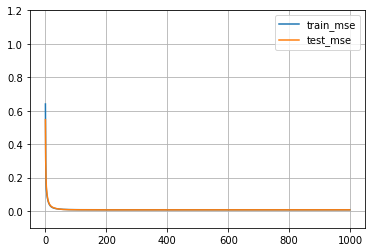

In [10]:
df = pd.DataFrame(history)
df.plot(grid=True)
plt.ylim(-0.1, 1.2)
plt.show()